# Simulation Study
We run a number of experimental simulations to compare the simulation bounds established by Dalalyan with the traditionally used Gelman-Rubin diagnostic, the potential scale reduction factor (PSRF) known as R.hat.

In [2]:
from __future__ import division
import numpy as np
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Background

### Logistic Regression 

The focus of this study will be on a Bayesian approach to fitting a logistic regression model, as this is a good example of a common and useful technique with posterior distribution satisfying certain important properties including strict log-concavity.

Given an iid sample $(X_i,Y_i)_{i=1,2,...,n}$ with $X_i \in \mathbb{R}^p$ and $Y_i \in \{ 0,1 \}$ we aim to estimate the conditional distribution of $Y_1$ given $X_1$, otherwise thought of as the regression function $r(x) = \textbf{P}(Y_1 = 1\;|\;X_1 = x)$. In logistic regression $r(x)$ is approximated by a logistic function $r(\theta, x) = e^{-\theta^T x}/(1+e^{-\theta^T x})$ and we try to discover the distribution of $\theta$.

Given a gaussian prior with mean zero and covariance proportional to the inverse of the Gram matrix $\mathbf{\Sigma_x}$, the posterior takes the form of:

$$ \pi(\theta) \propto exp \{ -Y^TX\theta - \sum_{i=1}^{n}log(1+e^{-\theta^T X_i}) - \frac{\lambda}{2}\theta^T \mathbf{\Sigma_x} \theta\}$$

Where Y is the vector of responses, X is the model matrix and $\lambda$ is chosen for convenience.

For our experiments we generate the data as follows. The features $X_i$ are drawn such that each coordinate takes values +-1 with probability 1/2 and then renormalised to have Euclidian norm of one. Each value of $Y_i$ given $X_i = x$ is drawn from a Bernoulli distribution with parameter $r(\theta^{true},x)$ setting $\theta^{true} = \mathbf{1}_P$. The code for this is given below.

In [22]:
def generate_data(samples=10, dim=1):
    
    def logistic(theta, x):
        
        y = np.exp(-np.dot(theta,x))
        z = y / (1 + y)
        
        return z
    
    thetatrue = [1,1]
    designX = np.zeros(shape=(samples,dim))
    Y = []
    
    for i in range(samples):
        
        xi = []
        
        for j in range(dim):
            
            xij = (stats.binom.rvs(1,p=0.5)*2)-1
            xi.append(xij)
            
        npxi = np.array(xi)
        norm = np.sqrt(np.sum(npxi**2))
        normxi = npxi / norm
        designX[i] = normxi
        
        yp = logistic(thetatrue, normxi)
        yi = stats.binom.rvs(1, p=yp)
        Y.append(yi)
    
    Y = np.array(Y)
    
    return designX, Y


X,Y = generate_data(100,2)

YtX = np.dot(Y,X)

xGram = np.zeros(shape=[len(X[0]),len(X[0])])

for i in range(len(X[:,0])):
    
    xxt = np.outer(X[i],X[i])
    xGram = xGram + xxt

xGram = xGram / len(X[:,0])

p = len(X[i])

lamda = (3*len(X[0])) / (np.pi**2)

w,v = np.linalg.eig(xGram)

M = (lamda + (0.25*len(X[:,0]))) * np.amax(w)
m = lamda * np.amin(w)

def logregd(theta):

    logs = np.log(1 + np.exp(-np.dot(X,theta)))
    logsum = np.sum(logs)
    xgramtheta = np.dot(xGram,theta)
    pdf = (- np.dot(YtX, theta) - logsum - 
            (((3*len(X[0]))/(2*np.pi**2)) 
            *(np.dot(theta,xgramtheta))))
    return pdf

def negative(theta):
    
    pdf = logregd(theta)
    
    return -pdf

### Langevin Monte Carlo
The idea behind LMC is to generate a markov chain $\upsilon^{(k,h)}$ that is the Euler discretisation of the continuous-time Langevin diffusion process that has $\pi$ as its invariant distribution. LMC is an approximate sampling algorithm and as the step size h $\rightarrow$ 0,  $\upsilon^{(k,h)} \rightarrow \pi$ meaning in practice we pick h to be as small as possible although a smaller step size naturally means the chain takes longer to explore the state-space.

The algorithm is defined iteratively, given an initial start point $\upsilon^{(0,h)}\in\mathbb{R}^p$ subsequent samples are picked as follows:

$$ \upsilon^{(k+1,h)} = \upsilon^{(k,h)} - h\nabla f(\upsilon^{(k+1,h)}) + \sqrt{2h}\xi^{(k+1)};\;\;k = 0,1,2...$$

Where $\xi^{(1)}, \xi^{(2)}...$ is a sequence of independant multivariate normal random variables with mean zero and covariance equal to the identity. 
Under some assumptions on $f$ and with $h$ small and $k$ large (so that the product $kh$ is large) then the distribution of $\upsilon^{(k,h)}$ is close in total variation to the distribution $\pi\;\propto\;e^{-f(\theta)}$. This is unlike some other MCMC algorithms such as the Metropolis-Hastings which have a accept/reject stage allowing the chain to converge in distribution to the target as the number of steps tends to infinity.

You will note that the logistic regression example as shown above satisfies the required conditions and considering  $f(\theta)$ we see:

$$\nabla f(\theta) =  X^TY - \sum_{i=1}^{n}\frac{X_i}{1+e^{\theta^T X_i}} + \lambda\mathbf{\Sigma_x}\theta$$

Based on the work of (Hanson et al., 2014), the parameter $\lambda$ is set at $3p/\pi^2$. We now detail code to implement LMC for this example of logistic regression below:

In [41]:
class langevin:
    
    def __init__(self, n, tune, nchains, dim):
        
        self.n = n
        self.tune = tune
        self.nchains = nchains
        self.dim = dim
        self.samples = np.zeros(shape=(n,nchains,dim))
        self.start = []
        self.noise = stats.multivariate_normal.rvs(size = (self.n*self.nchains),
                mean=np.zeros(self.dim), cov=np.identity(self.dim))
        
        XtY = np.dot(X.T,Y)
        
        thetastar = optimize.minimize(negative,np.zeros(self.dim))
        sigma = (1/M) * np.identity(self.dim)
        for i in range(self.nchains):
            self.start.append(stats.multivariate_normal.rvs(size=1, mean=thetastar.x, cov=sigma))
        
        def nabla_f(theta):
            
            logsum = np.zeros(self.dim)
            
            for i in range(len(X[:,0])):
                
                logs = X[i] / (1 + np.exp(np.dot(X[i],theta)))
                logsum = logsum + logs
                
            grad = (XtY + ((3*self.dim/(np.pi**2)) * np.dot(xGram,theta)) -
                    logsum)
            
            return grad
        
        for j in range(self.nchains):
            
            self.samples[0,j] = self.start[j]
            
            for i in range((self.n - 1)):
                
                xn = self.samples[i,j]
                
                xnplus = xn - (tune*nabla_f(xn)) + (np.sqrt(2*tune) * 
                                            self.noise[((j*self.n) + i)])
                    
                self.samples[(i+1),j] = xnplus
      
        
    def trace(self, dim=0):
        
        for j in range(self.nchains):
            plt.plot(self.samples[:,j,dim])
        
    def trace2d(self):
        
        cmap = {0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'w'}
        for j in range(self.nchains):
            plt.plot(self.samples[:,j,0],self.samples[:,j,1],
                     'C3', color=cmap[j])      
        plt.show()
        
    def kde(self, n=0):
        
        sns.jointplot(x = self.samples[:,n,0], y=self.samples[:,n,1], 
                      kind = "kde")    
    
    def diagnose(self):
                
        means = np.zeros(shape=[self.nchains,self.dim])
        
        for j in range(self.nchains):
            
            chain = np.array(self.samples[:,j,:])
            ave = sum(chain) / self.n 
            means[j,:] = ave
            
        within = np.zeros(shape=[self.dim,self.dim])
        
        for j in range(self.nchains):
            
            for i in range(self.n):
                
                dif = self.samples[i,j,:] - means[j,:]
                sqdif = np.outer(dif, dif.transpose())
                
                within = within + sqdif
            
        wvar = (1/(self.nchains * (self.n - 1))) * within
        
        tmean = sum(means) / self.nchains
        
        tss = np.zeros(shape=[self.dim,self.dim])
        
        for j in range(self.nchains):
            
            dif = means[j] - tmean
            sqdif = np.outer(dif,dif.transpose())
            
            tss = tss + sqdif
        
        bvar = (1/(self.nchains - 1)) * tss
            
        pdmatrix = np.dot(np.linalg.inv(wvar),bvar)
        
        w1,v1 = np.linalg.eig(pdmatrix)
        
        lamda = np.amax(w1)
        
        Rhat = ((self.n-1)/self.n)+(((self.nchains+1)/self.nchains)*lamda)
        self.psrf = Rhat
        print("PSRF value: ") + str(Rhat)

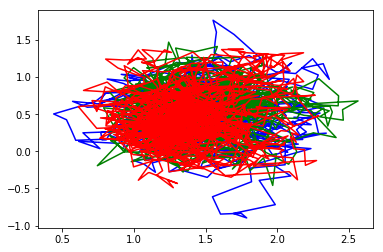

PSFR value: 1.0408791802


In [36]:
test = langevin(1000,0.01,3,2)
test.trace2d()
test.diagnose()

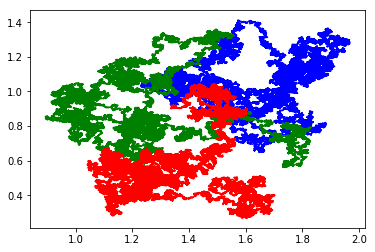

PSRF value: 4.3465227697


In [73]:
test2.trace2d()
test2.diagnose()

## Establishing Theoretical Bounds

In his 2016 paper "Theoretical guarantees for approximate sampling from smooth and log-concave densities" Dalalyan establishes sharp upper bounds on the number of iterations required to be within a certain error of the target distribution in LMC under certain conditions satisfied by our logistic regression example including the log-concavity of the density. We specifically consider the second theorem presented and its corrollary showing that given a specified error rate $\epsilon \in (0,1/2)$ we can calculate a time horizon $T$ and step size $h$ such that the total variation between the chain and the target will be less than the error as such:

$$ T = \frac{4\log(1/\epsilon) + p\log(M/m)}{2m},\;\; h = \frac{\epsilon^2(2\alpha - 1)}{M^2Tp\alpha}$$

Where $\alpha = (1 + MpT\epsilon^{-2})/2$ though can be specified differently subject to certain conditions. We define a function of $\epsilon$ to return these values:

In [38]:
def bounds(epsilon):
    
    T = ((4*np.log(1/epsilon)) + (p*np.log(M/m))) / (2*m)
    alpha = (1 + ((M*p*T)/(epsilon**(2)))) / 2
    h = ((epsilon**2)*((2*alpha)-1)) / ((M**2)*T*p*alpha)
    k = int(T/h) + 1

    return k,h

We'll first see how the number of required iterations behaves at the limit of the acceptable error (0.5), the number of iterations required increases as the error goes down so this should give us the least computationally expensive experiment. As well if it shows even at this relatively high value for $\epsilon$ we have a low PSRF lowering $\epsilon$ further will not tell us much.

In [83]:
bounds(0.5)

(365000, 5.6687194826412843e-05)

In [84]:
steps, tune = bounds(0.5)

In [79]:
test3 = langevin(steps,tune,3,2)

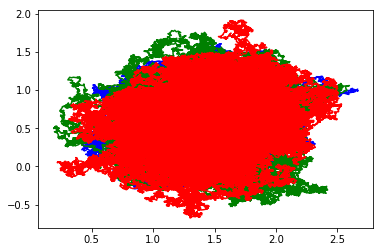

PSRF value: 1.00581579201


In [80]:
test3.trace2d()
test3.diagnose()

Looks good, we'll now generate 50 more to see if this was a one off and have a look at the distribution.

In [103]:
R_hats = []
for j in range(50):
    chain = langevin(steps,tune,3,2)
    chain.diagnose()
    R_hats.append(chain.psrf)
    

PSRF value: 1.02931714482
PSRF value: 1.03750929938
PSRF value: 1.03567530332
PSRF value: 1.00751708236
PSRF value: 1.00998702831
PSRF value: 1.01988325072
PSRF value: 1.03962755691
PSRF value: 1.03145513389
PSRF value: 1.0327864118
PSRF value: 1.00461924223
PSRF value: 1.01170948017
PSRF value: 1.01043520427
PSRF value: 1.00873879849
PSRF value: 1.01140953665
PSRF value: 1.00842991285
PSRF value: 1.00765693706
PSRF value: 1.031584573
PSRF value: 1.10530198625
PSRF value: 1.01805784154
PSRF value: 1.03898460094
PSRF value: 1.01612040608
PSRF value: 1.03208633943
PSRF value: 1.01909170378
PSRF value: 1.0512938921
PSRF value: 1.02281530795
PSRF value: 1.04107428198
PSRF value: 1.02693219316
PSRF value: 1.02444153262
PSRF value: 1.06575641769
PSRF value: 1.01176428902
PSRF value: 1.03386179544
PSRF value: 1.01592398269
PSRF value: 1.08459459413
PSRF value: 1.0123669586
PSRF value: 1.02924963184
PSRF value: 1.00540734179
PSRF value: 1.03238903929
PSRF value: 1.06405150995
PSRF value: 1.006

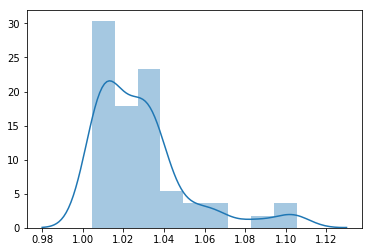

In [104]:
sns.distplot(R_hats)


Encouraging, the vast majority are below 1.05 and only one is above 1.1 and even then only very slightly. Remembering this is at the largest error rate, which if we were to lower would only result in more iterations recomended it seems we can infer these bounds are very conservative. We'll therefore try and find a lower number of iterations that we can run that will never the less reult in a consistently low PSRF.

In [90]:
Rhats = []
for j in range(50):
    chain = langevin(1000,0.01,3,2)
    chain.diagnose()
    Rhats.append(chain.psrf)

PSRF value: 1.00319351159
PSRF value: 1.04373969405
PSRF value: 1.00267720868
PSRF value: 1.01291423715
PSRF value: 1.07790875483
PSRF value: 1.03587458006
PSRF value: 1.0849403828
PSRF value: 1.04737702584
PSRF value: 1.01768996223
PSRF value: 1.08123021197
PSRF value: 1.02040228121
PSRF value: 1.03498255434
PSRF value: 1.04106869096
PSRF value: 1.05256900577
PSRF value: 1.02866930344
PSRF value: 1.02185027499
PSRF value: 1.01014364625
PSRF value: 1.05334448131
PSRF value: 1.06572353314
PSRF value: 1.04546142933
PSRF value: 1.01715536079
PSRF value: 1.03609143768
PSRF value: 1.05891667447
PSRF value: 1.12185135252
PSRF value: 1.02622762009
PSRF value: 1.04094330002
PSRF value: 1.00713667631
PSRF value: 1.09945651171
PSRF value: 1.00082878546
PSRF value: 1.09099672713
PSRF value: 1.03197476944
PSRF value: 1.04980990501
PSRF value: 1.0382965746
PSRF value: 1.0125482464
PSRF value: 1.04154466979
PSRF value: 1.1113967801
PSRF value: 1.11858566875
PSRF value: 1.02345118844
PSRF value: 1.04

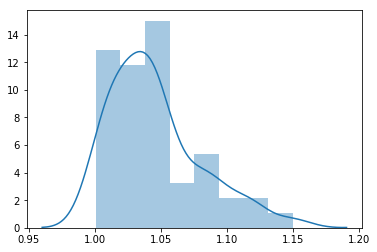

In [91]:
sns.distplot(Rhats)


This is good but the number of iterations is strongly related to the step size, which above was arbitrarily chosen, so we'll repeat but with the same step size as in the original experiment.

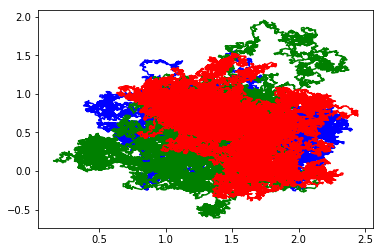

PSRF value: 1.13846407895


In [98]:
chain = langevin(60000,tune,3,2)
chain.trace2d()
chain.diagnose()

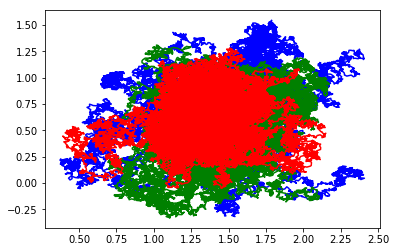

PSRF value: 1.21881048745


In [114]:
test4 = langevin(50000,tune,3,2)
test4.trace2d()
test4.diagnose()

In [115]:
R_hats2 = []
for j in range(10):
    chain = langevin(50000,tune,3,2)
    chain.diagnose()
    R_hats2.append(chain.psrf)

PSRF value: 1.10979410439
PSRF value: 1.04945156322
PSRF value: 1.21956148268
PSRF value: 1.08504255095
PSRF value: 1.45015410995
PSRF value: 1.00879611516
PSRF value: 1.04512021935
PSRF value: 1.08322457978
PSRF value: 1.05922681743
PSRF value: 1.08164437356


In [116]:
test4 = langevin(12051,7.60777683855e-05,3,2)

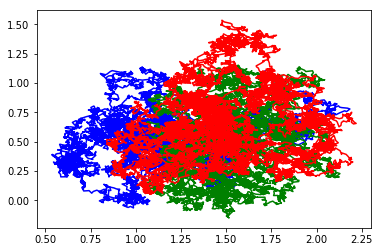

PSRF value: 1.53457775849


In [117]:
test4.trace2d()
test4.diagnose()

In [118]:
tune

5.6687194826412843e-05

Looking at the formula for the bounds it is clear that the values of M and m have a big impact on the number of iterations and step size chosen. These numbers are in turn entirely dependant on the choice of lambda, this seems odd considering lamda is an arbitrarily chosen constant so let us explore its effects.

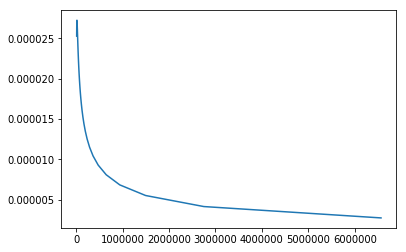

In [8]:
steps = []
tunes = []

for i in range(100):
    lamda = i/2 + 1
    M = (lamda + (0.25*len(X[:,0]))) * np.amax(w)
    m = lamda * np.amin(w)
    steps1,tune1 = bounds(0.1)
    steps.append(steps1)
    tunes.append(tune1)

plt.plot(steps,tunes)

It seems we can make the number of iterations as small as we like by just choosing a very high value of lambda, for example: 

In [9]:
lamda = 50
M = (lamda + (0.25*len(X[:,0]))) * np.amax(w)
m = lamda * np.amin(w)
bounds(0.1)

(9133, 2.5360675374884617e-05)

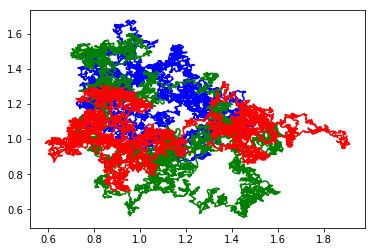

PSRF value: 1.40757064817


In [14]:
steps,tune = bounds(0.1)
test4_1 = langevin(steps,tune,3,2)
test4_1.trace2d()
test4_1.diagnose()

### Langevin for the Standard Normal 

Now we've looked at Logistic Regression we'll move on to another example that fits the required criteria, the standard Normal(0,1) distribution. This is a much simpler example with a much simpler gradient function and as a result is much quicker to run. Additionally the associated m/M values for the log-concavity are both equal to one which should make for lower bounds derived from the literature. 


In [119]:
class Nlangevin:
    
    def __init__(self, n, tune, nchains, dim):
        
        self.n = n
        self.tune = tune
        self.nchains = nchains
        self.dim = dim
        self.samples = np.zeros(shape=(n,nchains,dim))
        self.start = []
        self.noise = stats.multivariate_normal.rvs(size = (self.n*self.nchains),
                mean=np.zeros(self.dim), cov=np.identity(self.dim))
        self.psrf = 0
        
        m=1
        M=1
        
        sigma = (1/M) * np.identity(self.dim)
        for i in range(self.nchains):
            self.start.append(stats.multivariate_normal.rvs(size=1, 
                                        mean=np.zeros(dim), cov=sigma))
        
        for j in range(self.nchains):
            
            for i in range(self.n):
                
                if i == 0:
                    
                    self.samples[0,j] = self.start[j]
                    
                else:
                    
                    i2 = i - 1
                    xn = self.samples[i2,j]
                    
                    xnplus = xn - (tune*xn) + (np.sqrt(2*tune) * 
                                               self.noise[((j*self.n) + i)])
                    
                    self.samples[i,j] = xnplus
      

    def trace2d(self):
        
        cmap = {0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'w'}
        for j in range(self.nchains):
            plt.plot(self.samples[:,j,0],self.samples[:,j,1],
                     'C3', color=cmap[j])       
    
    def kde(self, n=0):
        
        sns.jointplot(x = self.samples[:,n,0], y=self.samples[:,n,1], 
                      kind = "kde")    
    
    def diagnose(self):
                
        means = np.zeros(shape=[self.nchains,self.dim])
        
        for j in range(self.nchains):
            
            chain = np.array(self.samples[:,j,:])
            ave = sum(chain) / self.n 
            means[j,:] = ave
            
        within = np.zeros(shape=[self.dim,self.dim])
        
        for j in range(self.nchains):
            
            for i in range(self.n):
                
                dif = self.samples[i,j,:] - means[j,:]
                sqdif = np.outer(dif, dif.transpose())
                
                within = within + sqdif
            
        wvar = (1/(self.nchains * (self.n - 1))) * within
        
        tmean = sum(means) / self.nchains
        
        tss = np.zeros(shape=[self.dim,self.dim])
        
        for j in range(self.nchains):
            
            dif = means[j] - tmean
            sqdif = np.outer(dif,dif.transpose())
            
            tss = tss + sqdif
        
        bvar = (1/(self.nchains - 1)) * tss
            
        pdmatrix = np.dot(np.linalg.inv(wvar),bvar)
        
        w,v = np.linalg.eig(pdmatrix)
        
        lamda = np.amax(w)
        
        Rhat = ((self.n-1)/self.n)+(((self.nchains+1)/self.nchains)*lamda)
        self.psrf = Rhat
        print("PSRF value: ") + str(Rhat)
        

PSRF value: 1.00427560764


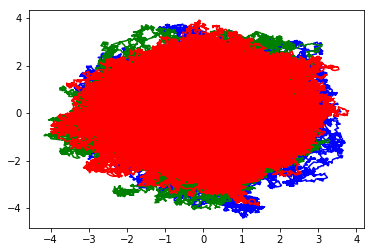

In [127]:
test5 = Nlangevin(1000000,0.001,3,2)
test5.trace2d()
test5.diagnose()

In [128]:
m,M = (1,1)
bounds(0.1)

(2124, 0.0021691173203092317)

PSRF value: 2.50902571174


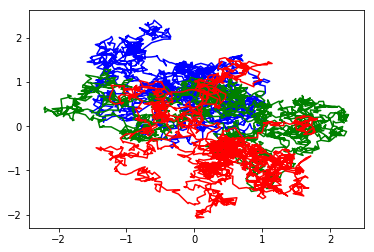

In [130]:
steps, tune = bounds(0.1)
test6 = Nlangevin(steps,tune,3,2)
test6.trace2d()
test6.diagnose()

Very interestingly these bounds are significantly lower than those derived for the LR examples, moreover the chain does not appear to have converged, or at least the PSRF is much higher than any value that could reasonably represent convergance. We'll repeat the experiment a few times to get a better understanding of how the chain behaves with these conditions. 

PSRF value: 1.49891643571
PSRF value: 1.82789342445
PSRF value: 1.31001746444
PSRF value: 1.44653324033
PSRF value: 1.66163694378
PSRF value: 1.176387485
PSRF value: 2.05530815278
PSRF value: 4.21194795569
PSRF value: 8.91717915762
PSRF value: 1.24666907216
PSRF value: 2.1152413313
PSRF value: 1.64092511022
PSRF value: 2.10747270947
PSRF value: 4.0047749636
PSRF value: 2.6188273129
PSRF value: 3.5919964073
PSRF value: 1.51357966206
PSRF value: 2.97049628127
PSRF value: 6.67295307516
PSRF value: 1.30803646838
PSRF value: 1.43599867103
PSRF value: 3.48677725427
PSRF value: 1.80089360993
PSRF value: 2.05938834163
PSRF value: 1.54697904617
PSRF value: 1.90266254214
PSRF value: 4.05903991921
PSRF value: 1.84063902614
PSRF value: 3.33864694357
PSRF value: 2.52318848754
PSRF value: 2.26628599038
PSRF value: 1.31622156182
PSRF value: 2.8089006455
PSRF value: 1.55097852427
PSRF value: 2.77633072957
PSRF value: 3.11834345636
PSRF value: 2.56809518429
PSRF value: 2.0384577165
PSRF value: 2.015122

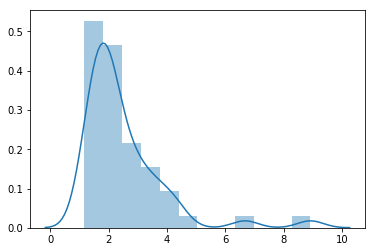

In [131]:
R_hats3 = []
for j in range(50):
    chain = Nlangevin(steps,tune,3,2)
    chain.diagnose()
    R_hats3.append(chain.psrf)

sns.distplot(R_hats3)

In [132]:
np.amin(R_hats3)

1.176387485000213

The PSRF values we're getting here are much higher than ones that would typically be used to signify that convergance has been reached. Typically we'd look for values below 1.05-1.1 but these are much higher, indeed out of all of them the smallest is 1.18. In order to consistently get low values we have to increase the number of iterations quite significantly of more than an order of magnitude as we will show in the next test.

PSRF value: 1.07722703492
PSRF value: 1.05782358098
PSRF value: 1.04834917646
PSRF value: 1.07326730562
PSRF value: 1.09088543427
PSRF value: 1.05171623473
PSRF value: 1.01695299212
PSRF value: 1.07832320048
PSRF value: 1.02758189912
PSRF value: 1.01097460364
PSRF value: 1.03133327084
PSRF value: 1.08390117246
PSRF value: 1.06644964961
PSRF value: 1.05000756164
PSRF value: 1.12359539128
PSRF value: 1.14852287661
PSRF value: 1.04422178717
PSRF value: 1.09014912497
PSRF value: 1.14451929198
PSRF value: 1.16694928823
PSRF value: 1.01020471346
PSRF value: 1.06309168531
PSRF value: 1.05013838298
PSRF value: 1.10387012763
PSRF value: 1.02799603453
PSRF value: 1.02361776709
PSRF value: 1.04579488843
PSRF value: 1.07458060849
PSRF value: 1.00221127256
PSRF value: 1.0444523841
PSRF value: 1.13357924954
PSRF value: 1.06993851317
PSRF value: 1.02088917248
PSRF value: 1.04930473282
PSRF value: 1.09762633869
PSRF value: 1.03286810191
PSRF value: 1.08025445441
PSRF value: 1.05652480439
PSRF value: 1

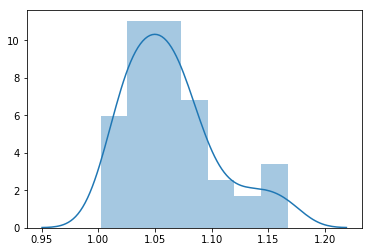

In [133]:
R_hats4 = []
for j in range(50):
    chain = Nlangevin(30000,tune,3,2)
    chain.diagnose()
    R_hats4.append(chain.psrf)

sns.distplot(R_hats4)

In [59]:
mratio = []
reqints = []
lamda = (3*len(X[0])) / (np.pi**2)
M = lamda
m = lamda
mratio.append(1)
reqints.append(bounds(0.1))

for j in range(24):
    
    X,Y = generate_data(((2*j)+2),2)

    YtX = np.dot(Y,X)

    xGram = np.zeros(shape=[len(X[0]),len(X[0])])

    for i in range(len(X[:,0])):
    
        xxt = np.outer(X[i],X[i])
        xGram = xGram + xxt

    xGram = xGram / len(X[:,0])

    lamda = (3*len(X[0])) / (np.pi**2)
    w,v = np.linalg.eig(xGram)

    M = (lamda + (0.25*len(X[:,0])))
    m = lamda

    mratio.append(M/m)
    reqints.append(bounds(0.1))
    
npints = np.array(reqints)


In [60]:
npints

array([[  2.12400000e+03,   3.56805498e-03],
       [  9.00500000e+03,   9.50931900e-04],
       [  2.17730000e+04,   4.21412507e-04],
       [  4.11360000e+04,   2.33874656e-04],
       [  6.76280000e+04,   1.47435575e-04],
       [  1.01680000e+05,   1.00896964e-04],
       [  1.43658000e+05,   7.31222467e-05],
       [  1.93877000e+05,   5.52827601e-05],
       [  2.52618000e+05,   4.31758692e-05],
       [  3.20131000e+05,   3.45996968e-05],
       [  3.96646000e+05,   2.83125587e-05],
       [  4.82371000e+05,   2.35721962e-05],
       [  5.77501000e+05,   1.99133540e-05],
       [  6.82214000e+05,   1.70327042e-05],
       [  7.96681000e+05,   1.47258180e-05],
       [  9.21058000e+05,   1.28509547e-05],
       [  1.05549600e+06,   1.13073967e-05],
       [  1.20013600e+06,   1.00220250e-05],
       [  1.35511100e+06,   8.94074353e-06],
       [  1.52055000e+06,   8.02285269e-06],
       [  1.69657500e+06,   7.23726849e-06],
       [  1.88330200e+06,   6.55992817e-06],
       [  

In [65]:
test=langevin(2000000,5.00744822e-06,3,2)
test.diagnose()

PSRF value: 1.00847409633


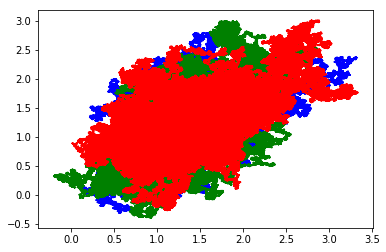

In [66]:
test.trace2d()

In [67]:
rsteps = (5.00744822e-06 * 2000000) / npints[:,1]

In [68]:
rsteps


array([    2806.82234711,    10531.66523819,    23765.06691613,
          42821.64051262,    67927.27222367,    99258.64993829,
         136961.00554187,   181157.6777852 ,   231955.87313665,
         289450.4103489 ,   353726.29366448,   424860.55807558,
         502923.63801938,   587980.41084481,   680091.01065761,
         779311.47538598,   885694.26976682,   999288.71409768,
        1120141.34012839,  1248296.18972726,  1383795.06797407,
        1526677.75950815,  1676982.21491987,  1834744.71247466,
        1999999.99934022])

<function matplotlib.pyplot.show>

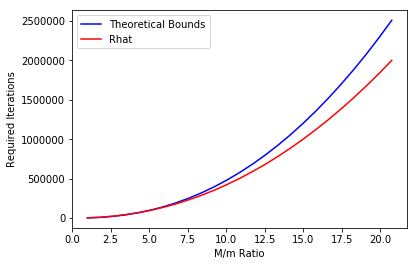

In [79]:
plt.plot(mratio[:], npints[:,0], color='blue', label="Theoretical Bounds")
plt.plot(mratio[:], rsteps[:], color='red', label="Rhat")
plt.xlabel("M/m Ratio")
plt.ylabel("Required Iterations")
plt.legend(loc='upper left')
plt.show

<function matplotlib.pyplot.show>

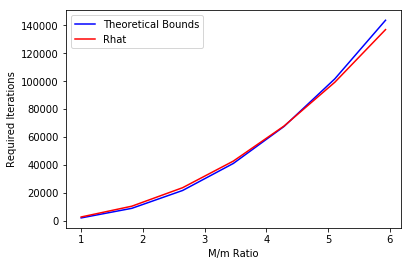

In [80]:
plt.plot(mratio[:7], npints[:7,0], color='blue', label="Theoretical Bounds")
plt.plot(mratio[:7], rsteps[:7], color='red', label="Rhat")
plt.xlabel("M/m Ratio")
plt.ylabel("Required Iterations")
plt.legend(loc='upper left')
plt.show

<function matplotlib.pyplot.show>

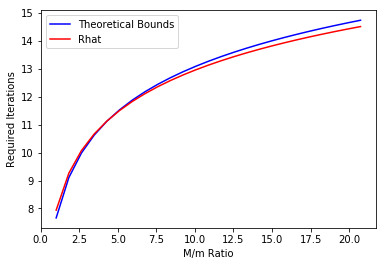

In [81]:
plt.plot(mratio[:], np.log(npints[:,0]), color='blue', label="Theoretical Bounds")
plt.plot(mratio[:], np.log(rsteps[:]), color='red', label="Rhat")
plt.xlabel("M/m Ratio")
plt.ylabel("Required Iterations")
plt.legend(loc='upper left')
plt.show